### Load Physical Variables

In [2]:

# fcst = np.array(fcst >= 20).astype(np.int8).flatten()


NameError: name 'rasterio' is not defined

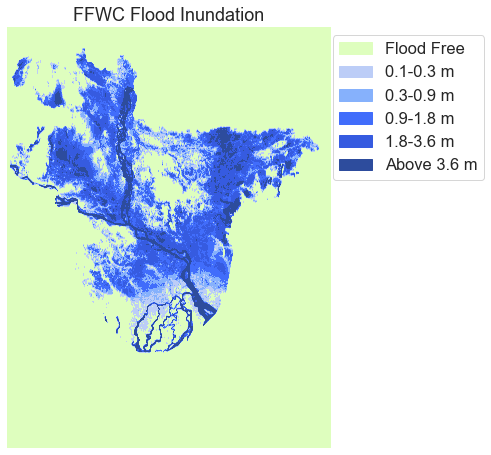

In [6]:
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import fiona
from descartes import PolygonPatch
import rasterio
sns.set(font_scale=1.5, style="white")


fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1)  # Flood depth (decuple)


## TODO: Overlay shapefile on the raster map



# Define the colors
class_bin = np.array([0,1.01,3,9,18,36,100])
class_label = ['Flood Free','0.1-0.3 m','0.3-0.9 m','0.9-1.8 m','1.8-3.6 m','Above 3.6 m']
class_rgb = [[222,254,190],[188,205,247],[134,177,252],[65,109,251],[54,91,224],[45,76,157]]
class_rgb = list(np.array(class_rgb)/255)
cmap = ListedColormap(class_rgb)
cmap.name = class_label
# Define a normalization from values -> colors
norm = colors.BoundaryNorm(class_bin, len(class_bin))

# Plot raster
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7), facecolor='w')
im = ax.imshow(fcst,cmap=cmap,norm=norm)
# Title
ax.set_title("FFWC Flood Inundation")
# Legend
patches = [ mpatches.Patch(color=class_rgb[i],label=class_label[i]) for i in range(len(class_label)) ]
ax.legend(handles=patches,bbox_to_anchor=(1.5, 1),facecolor="white")
# Post-setting
plt.tight_layout()
ax.set_axis_off()
plt.show()

In [7]:
fcst

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [ ]:
# Load code4 and code3
fn = os.path.join('land', 'boundary_gadm', 'gadm4_code.tif')
ds = gdal.Open(fn); dsCopy = ds
code4 = ds.GetRasterBand(1).ReadAsArray()
code3 = np.floor(code4/100)
nocode = (code4 == code4[0,0])

# Load census data
cens = np.load('data_census.npy'); cens = cens.item()
pop = cens['pop']


#%% Load variables
# Proximity to rivers (priv, 0-1)
# (1km:1, 2km:0.5, 3km:0.2, 4+km:0)
loc = './hydrology/river_proximity'
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_3km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv = np.zeros(data.shape)
priv[data != data[0,0]] = 2
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_2km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv[data != data[0,0]] = 5
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_1km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv[data != data[0,0]] = 10
# - Scale to 0-1
priv = fh.zeroToOne(priv)
fh.evaluation('priv', priv, code4)

# Proximity to cyclone shelters (pcsh, 0-1)
# (1km:0, 2km:0.33, 3km:0.67, 4+km:1)
loc = './hydrology/shelters_cyclone_proximity'
ds = gdal.Open(os.path.join(loc, 'cyclone_3km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh = np.ones(data.shape)
pcsh[data != data[0,0]] = 2/3
ds = gdal.Open(os.path.join(loc, 'cyclone_2km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh[data != data[0,0]] = 1/3
ds = gdal.Open(os.path.join(loc, 'cyclone_1km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh[data != data[0,0]] = 0
# - Scale to 0-1
pcsh = fh.zeroToOne(pcsh)
fh.evaluation('pcsh', pcsh, code4)

# Number of cyclone shelters per Upazila capita (ncsh, 0-1)
# (#shelters in Upazila / #pop in Upazila)
fn = os.path.join(os.path.join('hydrology','shelters_cyclone',
                               'cyclone_shelters_gadam4.xlsx'))
df = pd.ExcelFile(fn).parse('cyclone_shelters_gadam4')
#cshel_cc4 = df.Div_ID*10**6 + df.Dist_ID*10**4+df.Upz_ID*10**2+df.Un_ID
cshel_cc3 = df.Div_ID*10**4 + df.Dist_ID*10**2+df.Upz_ID
count = cshel_cc3.value_counts()
ncsh = np.empty(code3.shape); ncsh[:] = 0
for index, row in count.iteritems():
    ncsh[code3 == index] = row/pop[pop[:,0] == index,1]
# - Scale to 0-1
ncsh = 1 - fh.zeroToOne(ncsh)
fh.evaluation('ncsh', ncsh, code4)

# Number of PHC and Hospitals
fn = os.path.join(os.path.join('health','healthsites_lged', 'gadm4_join.xlsx'))
df = pd.ExcelFile(fn).parse('gadm4_join')
# - Number of Hospitals in Upazila (nhsp, 0-1)
code3_hosp = np.floor(df[df.FType == 'Hospital'].CC_4/100)
code3_hosp = code3_hosp.value_counts()
nhsp = np.empty(code3.shape); nhsp[:] = 0
for index, freq in code3_hosp.iteritems():
    nhsp[code3 == index] = freq
# - Scale to 0-1
nhsp = 1 - fh.zeroToOne(nhsp)
fh.evaluation('nhsp', nhsp, code4)
# - Number of PHC in Union (nphc, 0-1)
code4_phc = df[df.FType == 'Family Welfare Centre'].CC_4
code4_phc = code4_phc.value_counts()
nphc = np.empty(code4.shape); nphc[:] = 0
for index, freq in code4_phc.iteritems():
    nphc[code4 == index] = freq
# - Scale to 0-1
nphc = 1 - fh.zeroToOne(nphc)
fh.evaluation('nphc', nphc, code4)

# Slope (slop, 0-1)
fn = os.path.join('land','slope_hydrosheds','slope_wgs84.tif')
ds = gdal.Open(fn)
data = ds.GetRasterBand(1).ReadAsArray().astype('float32')   # (728, 559)
slop = data[1:,:]                                            # (727, 559)
slop[slop == slop[0,0]] = 0
# - Scale to 0-1
slop[code4 == code4[0,0]] = 0
slop[slop != 0] = np.log(slop[slop != 0])
slop[slop != 0] = fh.zeroToOne(slop[slop != 0])
fh.evaluation('slop', slop, code4)

# Climate: WorldClim
loc = os.path.join('hydrology', 'clim_worldclim')
prec = np.empty((727,559,4)); prec[:] = np.nan
tavg = np.empty((727,559,4)); tavg[:] = np.nan
wind = np.empty((727,559,4)); wind[:] = np.nan
for i in range(4):
    # - Precipitation (prec, 0-1)
    ds = gdal.Open(os.path.join(loc,'prec_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        prec[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        prec[:,:,i] = temp[:-1,1:]
    # - Temperature (tavg, 0-1)
    ds = gdal.Open(os.path.join(loc,'tavg_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        tavg[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        tavg[:,:,i] = temp[:-1,1:]
    # - Wind (wind, 0-1)
    ds = gdal.Open(os.path.join(loc,'wind_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        wind[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        wind[:,:,i] = temp[:-1,1:]
prec = np.mean(prec, axis=2); prec = fh.climInterpolate(prec, code4)
tavg = np.mean(tavg, axis=2); tavg = fh.climInterpolate(tavg, code4)
wind = np.mean(wind, axis=2); wind = fh.climInterpolate(wind, code4)
# - Scale to 0-1
prec[code4 != code4[0,0]] = fh.zeroToOne(np.log(prec[code4 != code4[0,0]]))
tavg[code4 != code4[0,0]] = fh.zeroToOne(tavg[code4 != code4[0,0]])
wind[code4 != code4[0,0]] = fh.zeroToOne(wind[code4 != code4[0,0]])
fh.evaluation('prec', prec, code4)
fh.evaluation('tavg', tavg, code4)
fh.evaluation('wind', wind, code4)

# Elevation (elev, 0 or 1)
# *elev <= 5: 1, elev > 5: 0
ds = gdal.Open(os.path.join('land','dem_hydrosheds','as_dem_30s_bgd.tif'))
elev = ds.GetRasterBand(1).ReadAsArray().astype(float)
elev[(elev >= 0) & (elev <= 5)] = 1
elev[(elev > 5) | (elev < 0)] = 0
fh.evaluation('elev', elev, code4)

# Poverty from WorldPop dataset
loc = os.path.join('socioecon', 'poverty_worldpop')
# DHS wealth score (wlth, 0-1)
ds = gdal.Open(os.path.join(loc, 'bgd2011wipov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
wlth = np.empty(code4.shape); wlth[:] = np.nan  # (727,559)
wlth[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (wlth == wlth[0,0]) | (np.isnan(wlth))
wlth[~rdx] = 1 - fh.zeroToOne(wlth[~rdx])
wlth[rdx] = 0
fh.evaluation('wlth', wlth, code4)
# Poverty (povt)
ds = gdal.Open(os.path.join(loc, 'bgd2013ppipov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
povt = np.empty(code4.shape); povt[:] = np.nan  # (727,559)
povt[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (povt == povt[0,0]) | (np.isnan(povt))
povt[~rdx] = fh.zeroToOne(povt[~rdx])
povt[rdx] = 0
fh.evaluation('povt', povt, code4)
# Income (incm)
ds = gdal.Open(os.path.join(loc, 'bgd2013incpov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
incm = np.empty(code4.shape); incm[:] = np.nan  # (727,559)
incm[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (incm == incm[0,0]) | (np.isnan(incm))
incm[~rdx] = 1 - fh.zeroToOne(incm[~rdx])
incm[rdx] = 0
fh.evaluation('incm', incm, code4)

# GDP (gdp, 0-1)
ds = gdal.Open(os.path.join('socioecon', 'gdp_kummu', 'gdp_ppp_2015_30s_bgd.tif'))
gdp = ds.GetRasterBand(1).ReadAsArray()         # (727,559)
rdx = np.isnan(gdp)
# - Scale to 0-1
gdp[~rdx] = 1 - fh.zeroToOne( np.log(gdp[~rdx]))
gdp[rdx] = 0
fh.evaluation('gdp', gdp, code4)

# Flood prone area (fpro, 0 or 1)
ds = gdal.Open(os.path.join('hydrology', 'flood prone area','fpro.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (727,559)
fpro = np.zeros(temp.shape)
fpro[temp == 0] = 1
fh.evaluation('fpro', fpro, code4)

# Flood depth (fdep, 0-1)
loc = os.path.join('hydrology', 'inundation_glofris')
ds = gdal.Open(os.path.join(loc, 'rp_00010.tif'))
fdep = ds.GetRasterBand(1).ReadAsArray().astype('float')    # (727,559)
fdep_copy = fdep.copy()
# - Scale to 0.5-1
fdep[fdep != 0] = fh.zeroToOne(fdep[fdep != 0])/2 + 0.5
fh.evaluation('fdep', fdep, code4)

# Accessibility to Healthcare facilities
# *Travel time (minutes) is categoraized to 1-7
# *Flooded areas are defined as the category of longest travel time
loc = os.path.join('health', 'traveltime_lged')
# - Travel time to PHC (tphc, 0-1)
ds = gdal.Open(os.path.join(loc, 'family2000_clip.tif'))    # (728,559)
tphc = ds.GetRasterBand(1).ReadAsArray()[1:,:]              # (727,559)
tphc[np.isnan(tphc)] = 0
ds = gdal.Open(os.path.join(loc, 'travel_family_rp00010_10p_clip.tif'))
tphc_flood = ds.GetRasterBand(1).ReadAsArray()[1:,:]        # (727,559)
tphc_flood[np.isnan(tphc_flood)] = 0
tphc_flood[(fdep_copy >= 10)] = 2000    # Max travel time to flooded area
# - Additional travel time to PHC (aphc, 0-1)
aphc = tphc_flood - tphc
# - Saving ATT to PHC (mins)
fn = os.path.join('health', 'traveltime_lged', 'aphc.tif')
temp = aphc.copy(); temp[nocode | np.isnan(temp)] = -9999
out_ds = fh.make_raster(dsCopy, fn, temp, gdal.GDT_Float32, -9999); del out_ds
# - Accessibility to Hospitals (thsp, 0-1)
ds = gdal.Open(os.path.join(loc, 'hospital_clip.tif'))      # (728,559)
thsp = ds.GetRasterBand(1).ReadAsArray()[1:,:]              # (727,559)
thsp[np.isnan(thsp)] = 0
ds = gdal.Open(os.path.join(loc, 'travel_hospital_rp00010_10p_clip.tif'))
thsp_flood = ds.GetRasterBand(1).ReadAsArray()[1:,:]        # (727,559)
thsp_flood[np.isnan(thsp_flood)] = 0
thsp_flood[(fdep_copy >= 10)] = 2000    # Max travel time to flooded area
# - Additional travel time to Hospitals (ahsp, 0-1)
ahsp = thsp_flood - thsp
# - Saving ATT to PHC (mins)
fn = os.path.join('health', 'traveltime_lged', 'ahsp.tif')
temp = ahsp.copy(); temp[nocode | np.isnan(temp)] = -9999
out_ds = fh.make_raster(dsCopy, fn, temp, gdal.GDT_Float32, -9999); del out_ds
# - Scale to 0-1
tphc = fh.zeroToOne(fh.timeToCategory(tphc)); tphc[np.isnan(tphc)] = 1
aphc = fh.zeroToOne(fh.timeToCategory(aphc)); aphc[np.isnan(aphc)] = 1
thsp = fh.zeroToOne(fh.timeToCategory(thsp)); thsp[np.isnan(thsp)] = 1
ahsp = fh.zeroToOne(fh.timeToCategory(ahsp)); ahsp[np.isnan(ahsp)] = 1
fh.evaluation('tphc', tphc, code4)
fh.evaluation('aphc', aphc, code4)
fh.evaluation('thsp', thsp, code4)
fh.evaluation('ahsp', ahsp, code4)

# Save files
fn = 'data_indices'
data = {'priv':priv,'pcsh':pcsh,'ncsh':ncsh,'nhsp':nhsp,'nphc':nphc,'slop':slop,
        'prec':prec,'tavg':tavg,'wind':wind,'elev':elev,'wlth':wlth,'povt':povt,
        'incm':incm,'gdp':gdp,'fpro':fpro,'tphc':tphc,'aphc':aphc,'thsp':thsp,
        'ahsp':ahsp, 'fdep':fdep}
np.save(fn, data)
print('{}.npy is saved..'.format(fn))